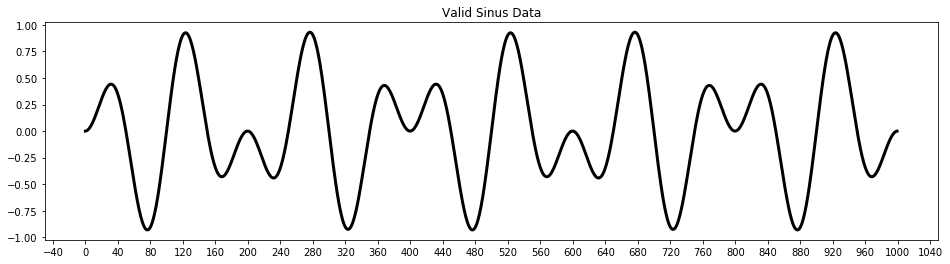

In [6]:
# Setting up packages for data manipulation and machine learning
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, Activation

# Creating the sample sinus curve dataset
steps = 1000; gradient = 0.002
list_a = []
for i in range(0, steps, 1):
    y = round(math.sin(math.pi * i * 0.02 + 0.01), 4) * round(math.sin(math.pi * i * 0.005 + 0.01), 4)
    list_a.append(y)
df = pd.DataFrame({"valid": list_a}, columns=["valid"])

# Visualizing the data
fig, ax1 = plt.subplots(figsize=(16, 4))
ax1.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.title("Valid Sinus Data")
plt.plot(df[["valid"]], color="black", linewidth=3.0)
plt.show()

In [7]:
# Settings
epochs = 2; batch_size = 1; lstm_neuron_number = 15

# Get the number of rows to train the model on 80% of the data
npdataset = df.values
training_data_length = math.ceil(len(npdataset) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = mmscaler.fit_transform(npdataset)

# Create a scaled training data set
train_data = scaled_data[0:training_data_length, :]

# Split the data into x_train and y_train data sets
x_train = []; y_train = []
trainingdatasize = len(train_data)
for i in range(lstm_neuron_number, trainingdatasize):
    x_train.append(train_data[i - lstm_neuron_number : i, 0]) 
    y_train.append(train_data[i, 0])  # contains all other values

# Convert the x_train and y_train to numpy arrays
x_train = np.array(x_train); y_train = np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print("x_tain.shape: " + str(x_train.shape) + " -- y_tain.shape: " + str(y_train.shape))

# Configure and compile the neural network model
model1 = Sequential()
model1.add(
    LSTM(lstm_neuron_number, return_sequences=False, input_shape=(x_train.shape[1], 1))
)
model1.add(Dense(1))
model1.compile(optimizer="adam", loss="mean_squared_error")

# Create the data sets x_test and y_test
test_data = scaled_data[training_data_length - lstm_neuron_number :, :]
x_test = []
y_test = npdataset[training_data_length:, :]
for i in range(lstm_neuron_number, len(test_data)):
    x_test.append(test_data[i - lstm_neuron_number : i, 0])

x_tain.shape: (785, 15, 1) -- y_tain.shape: (785,)


In [8]:
# Train the model
history = model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

# Reshape the data, so that we get an array with multiple test datasets
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the predicted values
predictions = model1.predict(x_test)
predictions = mmscaler.inverse_transform(predictions)

Epoch 1/2
785/785 [==============================] - 5s 6ms/step - loss: 0.0148
Epoch 2/2
785/785 [==============================] - 4s 5ms/step - loss: 4.5162e-04


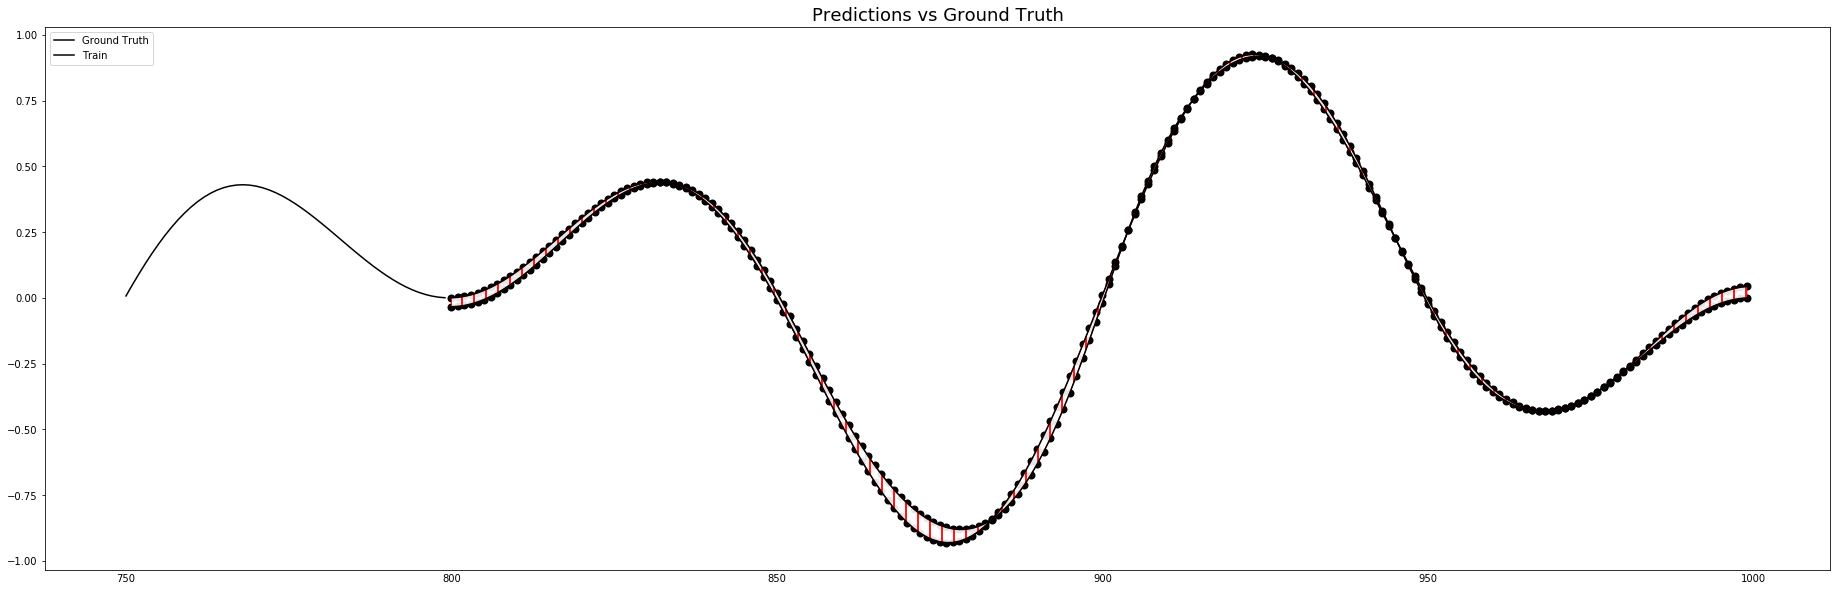

In [9]:
# Visualize the data
train = df[:training_data_length]; valid = df[training_data_length:]
valid.insert(1, "Predictions", predictions, True)
fig, ax1 = plt.subplots(figsize=(32, 10), sharex=True)
xt = valid.index; yt = train[["valid"]]
xv = valid.index; yv = valid[["valid", "Predictions"]]
ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
plt.title("Predictions vs Ground Truth", fontsize=18)
plt.plot(yv["Predictions"], color="black")
plt.scatter(xv, yv["Predictions"], color="black", linewidth=2)
plt.plot(yv["valid"], color="black")
plt.scatter(xv, yv["valid"], color="black", linewidth=2)
plt.plot(yt["valid"][750:800], color="black")
plt.legend(["Ground Truth", "Train"], loc="upper left")

# Fill between plotlines
import matplotlib as mpl
mpl.rc('hatch', color='k', linewidth=2)
ax1.fill_between(xv, yv["valid"], yv["Predictions"],  facecolor = 'white', hatch="|",  edgecolor="red", alpha=.9) 
plt.show()

In [10]:
# Mean Absolute Error (MAE)
MAE = np.mean(predictions - y_test)
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 3)))

# Mediann Absolute Error (MedAE)
MAE = np.median(predictions - y_test)
print('Median Absolute Error (MAE): ' + str(np.round(MAE, 3)))

# Mean Squared Error (MSE)
ME = np.mean(predictions - y_test)  ** 2
print('Mean Squared Error (MSE): ' + str(np.round(ME, 3)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(predictions - y_test) ** 2)
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 3)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean(np.abs((y_test-predictions) / y_test)) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 3)))

Mean Absolute Error (MAE): 0.004
Median Absolute Error (MAE): 0.001
Mean Squared Error (MSE): 0.0
Root Mean Squared Error (RMSE): 0.004
Mean Absolute Percentage Error (MAPE): 286.849
